<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:02<00:00, 59.4MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


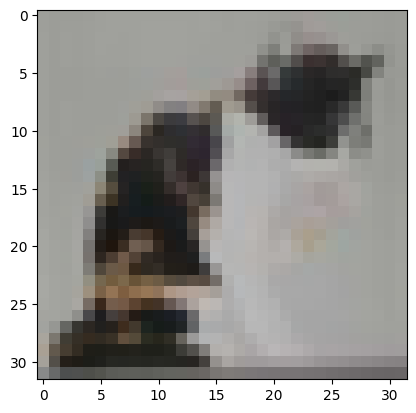

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train), transforms.RandomRotation(degrees=(-40, 40))])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [6]:
#Creating dataloader
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# **II. Model implementation**

In [7]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.ReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [8]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [9]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers:
      x = fc_layer(x)
    return x


# **III. Training and test**

In [10]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 64)
out_channels = (64, 128)
conv_kernels = (5, 5)
fc_dims = (out_channels[-1]*5*5, 256, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=3200, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [11]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 1063434
Device is cuda


In [12]:
if device=="cuda": model = torch.compile(model)

In [13]:
optimizer = None #Just so that I can resume training

In [14]:
#Training and validation
nb_epochs = 100
if optimizer is None: optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
else: print(optimizer)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
    loss_val /= len(val_loader)
    if loss_val < best_loss:
      best_loss = loss_val
      best_model, best_epoch = model, epoch
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()


Epoch: 0


391it [00:40,  9.59it/s]
40it [00:01, 35.59it/s]


Loss_train: 1.7173 and loss_val: 1.4494
Epoch: 1


391it [00:39,  9.78it/s]
40it [00:01, 35.68it/s]


Loss_train: 1.4566 and loss_val: 1.2990
Epoch: 2


391it [00:39,  9.83it/s]
40it [00:01, 35.58it/s]


Loss_train: 1.3389 and loss_val: 1.2144
Epoch: 3


391it [00:39,  9.83it/s]
40it [00:01, 35.93it/s]


Loss_train: 1.2645 and loss_val: 1.1523
Epoch: 4


391it [00:39,  9.83it/s]
40it [00:01, 35.87it/s]


Loss_train: 1.2085 and loss_val: 1.1102
Epoch: 5


391it [00:39,  9.84it/s]
40it [00:01, 35.92it/s]


Loss_train: 1.1582 and loss_val: 1.0568
Epoch: 6


391it [00:39,  9.93it/s]
40it [00:01, 35.29it/s]


Loss_train: 1.1163 and loss_val: 1.0388
Epoch: 7


391it [00:40,  9.63it/s]
40it [00:01, 35.31it/s]


Loss_train: 1.0873 and loss_val: 1.0257
Epoch: 8


391it [00:40,  9.57it/s]
40it [00:01, 34.61it/s]


Loss_train: 1.0589 and loss_val: 0.9751
Epoch: 9


391it [00:41,  9.53it/s]
40it [00:01, 35.62it/s]


Loss_train: 1.0280 and loss_val: 0.9801
Epoch: 10


391it [00:41,  9.45it/s]
40it [00:01, 33.12it/s]


Loss_train: 1.0057 and loss_val: 0.9508
Epoch: 11


391it [00:42,  9.16it/s]
40it [00:01, 34.60it/s]


Loss_train: 0.9855 and loss_val: 0.9322
Epoch: 12


391it [00:42,  9.23it/s]
40it [00:01, 34.11it/s]


Loss_train: 0.9672 and loss_val: 0.9165
Epoch: 13


391it [00:41,  9.39it/s]
40it [00:01, 34.86it/s]


Loss_train: 0.9535 and loss_val: 0.9477
Epoch: 14


391it [00:41,  9.47it/s]
40it [00:01, 35.32it/s]


Loss_train: 0.9370 and loss_val: 0.9050
Epoch: 15


391it [00:41,  9.52it/s]
40it [00:01, 34.96it/s]


Loss_train: 0.9182 and loss_val: 0.9091
Epoch: 16


391it [00:41,  9.46it/s]
40it [00:01, 34.57it/s]


Loss_train: 0.9037 and loss_val: 0.9126
Epoch: 17


391it [00:40,  9.57it/s]
40it [00:01, 35.70it/s]


Loss_train: 0.8922 and loss_val: 0.8769
Epoch: 18


391it [00:40,  9.58it/s]
40it [00:01, 34.17it/s]


Loss_train: 0.8774 and loss_val: 0.8625
Epoch: 19


391it [00:40,  9.65it/s]
40it [00:01, 35.45it/s]


Loss_train: 0.8692 and loss_val: 0.8966
Epoch: 20


391it [00:40,  9.69it/s]
40it [00:01, 34.35it/s]


Loss_train: 0.8572 and loss_val: 0.8829
Epoch: 21


391it [00:40,  9.66it/s]
40it [00:01, 33.40it/s]


Loss_train: 0.8466 and loss_val: 0.8724
Epoch: 22


391it [00:43,  9.04it/s]
40it [00:01, 36.01it/s]


Loss_train: 0.8388 and loss_val: 0.8697
Epoch: 23


391it [00:41,  9.51it/s]
40it [00:01, 34.55it/s]


Loss_train: 0.8265 and loss_val: 0.8542
Epoch: 24


391it [00:40,  9.55it/s]
40it [00:01, 35.06it/s]


Loss_train: 0.8181 and loss_val: 0.8656
Epoch: 25


391it [00:40,  9.60it/s]
40it [00:01, 35.60it/s]


Loss_train: 0.8105 and loss_val: 0.8556
Epoch: 26


391it [00:41,  9.44it/s]
40it [00:01, 35.71it/s]


Loss_train: 0.8020 and loss_val: 0.8574
Epoch: 27


391it [00:39,  9.83it/s]
40it [00:01, 35.94it/s]


Loss_train: 0.7958 and loss_val: 0.8323
Epoch: 28


391it [00:39,  9.87it/s]
40it [00:01, 36.12it/s]


Loss_train: 0.7875 and loss_val: 0.8206
Epoch: 29


391it [00:40,  9.77it/s]
40it [00:01, 34.70it/s]


Loss_train: 0.7838 and loss_val: 0.8315
Epoch: 30


391it [00:42,  9.30it/s]
40it [00:01, 33.46it/s]


Loss_train: 0.7760 and loss_val: 0.8213
Epoch: 31


391it [00:41,  9.31it/s]
40it [00:01, 35.04it/s]


Loss_train: 0.7686 and loss_val: 0.8263
Epoch: 32


391it [00:41,  9.45it/s]
40it [00:01, 35.34it/s]


Loss_train: 0.7602 and loss_val: 0.8369
Epoch: 33


391it [00:41,  9.51it/s]
40it [00:01, 35.06it/s]


Loss_train: 0.7562 and loss_val: 0.8167
Epoch: 34


391it [00:40,  9.55it/s]
40it [00:01, 34.18it/s]


Loss_train: 0.7530 and loss_val: 0.8292
Epoch: 35


391it [00:40,  9.56it/s]
40it [00:01, 35.42it/s]


Loss_train: 0.7461 and loss_val: 0.8064
Epoch: 36


391it [00:40,  9.57it/s]
40it [00:01, 34.00it/s]


Loss_train: 0.7365 and loss_val: 0.8067
Epoch: 37


391it [00:40,  9.54it/s]
40it [00:01, 34.23it/s]


Loss_train: 0.7328 and loss_val: 0.8165
Epoch: 38


391it [00:41,  9.41it/s]
40it [00:01, 34.93it/s]


Loss_train: 0.7277 and loss_val: 0.8243
Epoch: 39


391it [00:40,  9.56it/s]
40it [00:01, 35.32it/s]


Loss_train: 0.7255 and loss_val: 0.8080
Epoch: 40


391it [00:40,  9.54it/s]
40it [00:01, 35.40it/s]


Loss_train: 0.7211 and loss_val: 0.8046
Epoch: 41


391it [00:40,  9.63it/s]
40it [00:01, 35.23it/s]


Loss_train: 0.7186 and loss_val: 0.8166
Epoch: 42


391it [00:40,  9.55it/s]
40it [00:01, 34.76it/s]


Loss_train: 0.7095 and loss_val: 0.7954
Epoch: 43


391it [00:41,  9.51it/s]
40it [00:01, 35.73it/s]


Loss_train: 0.7100 and loss_val: 0.8147
Epoch: 44


391it [00:41,  9.54it/s]
40it [00:01, 34.94it/s]


Loss_train: 0.7055 and loss_val: 0.8054
Epoch: 45


391it [00:41,  9.49it/s]
40it [00:01, 34.57it/s]


Loss_train: 0.7023 and loss_val: 0.8217
Epoch: 46


391it [00:40,  9.55it/s]
40it [00:01, 35.30it/s]


Loss_train: 0.6964 and loss_val: 0.8135
Epoch: 47


391it [00:41,  9.53it/s]
40it [00:01, 34.60it/s]


Loss_train: 0.6920 and loss_val: 0.8034
Epoch: 48


391it [00:41,  9.50it/s]
40it [00:01, 34.85it/s]


Loss_train: 0.6934 and loss_val: 0.8201
Epoch: 49


391it [00:40,  9.55it/s]
40it [00:01, 35.76it/s]


Loss_train: 0.6847 and loss_val: 0.7870
Epoch: 50


391it [00:40,  9.60it/s]
40it [00:01, 35.31it/s]


Loss_train: 0.6843 and loss_val: 0.7978
Epoch: 51


391it [00:40,  9.55it/s]
40it [00:01, 34.43it/s]


Loss_train: 0.6762 and loss_val: 0.7960
Epoch: 52


391it [00:40,  9.58it/s]
40it [00:01, 34.59it/s]


Loss_train: 0.6733 and loss_val: 0.7869
Epoch: 53


391it [00:41,  9.50it/s]
40it [00:01, 33.68it/s]


Loss_train: 0.6701 and loss_val: 0.7927
Epoch: 54


391it [00:40,  9.57it/s]
40it [00:01, 35.48it/s]


Loss_train: 0.6721 and loss_val: 0.7918
Epoch: 55


391it [00:40,  9.55it/s]
40it [00:01, 35.45it/s]


Loss_train: 0.6652 and loss_val: 0.7865
Epoch: 56


391it [00:40,  9.54it/s]
40it [00:01, 33.05it/s]


Loss_train: 0.6647 and loss_val: 0.7891
Epoch: 57


391it [00:40,  9.58it/s]
40it [00:01, 35.00it/s]


Loss_train: 0.6582 and loss_val: 0.7950
Epoch: 58


391it [00:40,  9.55it/s]
40it [00:01, 35.33it/s]


Loss_train: 0.6608 and loss_val: 0.7914
Epoch: 59


391it [00:40,  9.58it/s]
40it [00:01, 35.19it/s]


Loss_train: 0.6524 and loss_val: 0.8027
Epoch: 60


391it [00:41,  9.50it/s]
40it [00:01, 34.42it/s]


Loss_train: 0.6555 and loss_val: 0.7896
Epoch: 61


391it [00:40,  9.56it/s]
40it [00:01, 34.87it/s]


Loss_train: 0.6475 and loss_val: 0.8015
Epoch: 62


391it [00:41,  9.47it/s]
40it [00:01, 35.04it/s]


Loss_train: 0.6442 and loss_val: 0.7804
Epoch: 63


391it [00:41,  9.44it/s]
40it [00:01, 35.46it/s]


Loss_train: 0.6475 and loss_val: 0.7991
Epoch: 64


391it [00:41,  9.49it/s]
40it [00:01, 34.74it/s]


Loss_train: 0.6394 and loss_val: 0.7896
Epoch: 65


391it [00:41,  9.47it/s]
40it [00:01, 35.11it/s]


Loss_train: 0.6334 and loss_val: 0.7939
Epoch: 66


391it [00:40,  9.56it/s]
40it [00:01, 35.68it/s]


Loss_train: 0.6338 and loss_val: 0.7919
Epoch: 67


391it [00:40,  9.56it/s]
40it [00:01, 35.01it/s]


Loss_train: 0.6295 and loss_val: 0.7929
Epoch: 68


391it [00:41,  9.52it/s]
40it [00:01, 34.59it/s]


Loss_train: 0.6272 and loss_val: 0.7908
Epoch: 69


391it [00:40,  9.57it/s]
40it [00:01, 34.67it/s]


Loss_train: 0.6267 and loss_val: 0.7989
Epoch: 70


391it [00:41,  9.53it/s]
40it [00:01, 34.42it/s]


Loss_train: 0.6270 and loss_val: 0.7957
Epoch: 71


391it [00:41,  9.46it/s]
40it [00:01, 34.78it/s]


Loss_train: 0.6222 and loss_val: 0.7927
Epoch: 72


391it [00:41,  9.50it/s]
40it [00:01, 35.25it/s]


Loss_train: 0.6153 and loss_val: 0.7955
Epoch: 73


391it [00:40,  9.61it/s]
40it [00:01, 35.42it/s]


Loss_train: 0.6154 and loss_val: 0.7858
Epoch: 74


391it [00:40,  9.72it/s]
40it [00:01, 35.60it/s]


Loss_train: 0.6119 and loss_val: 0.7709
Epoch: 75


391it [00:40,  9.73it/s]
40it [00:01, 34.08it/s]


Loss_train: 0.6163 and loss_val: 0.7947
Epoch: 76


391it [00:40,  9.71it/s]
40it [00:01, 35.61it/s]


Loss_train: 0.6110 and loss_val: 0.7820
Epoch: 77


391it [00:40,  9.64it/s]
40it [00:01, 35.94it/s]


Loss_train: 0.6082 and loss_val: 0.7979
Epoch: 78


391it [00:40,  9.65it/s]
40it [00:01, 36.04it/s]


Loss_train: 0.6070 and loss_val: 0.8074
Epoch: 79


391it [00:40,  9.71it/s]
40it [00:01, 35.53it/s]


Loss_train: 0.6056 and loss_val: 0.7990
Epoch: 80


391it [00:40,  9.72it/s]
40it [00:01, 36.00it/s]


Loss_train: 0.6011 and loss_val: 0.8079
Epoch: 81


391it [00:40,  9.71it/s]
40it [00:01, 36.14it/s]


Loss_train: 0.5990 and loss_val: 0.8059
Epoch: 82


391it [00:40,  9.66it/s]
40it [00:01, 35.85it/s]


Loss_train: 0.5989 and loss_val: 0.7857
Epoch: 83


391it [00:40,  9.69it/s]
40it [00:01, 35.62it/s]


Loss_train: 0.5930 and loss_val: 0.8015
Epoch: 84


391it [00:40,  9.70it/s]
40it [00:01, 36.34it/s]


Loss_train: 0.5986 and loss_val: 0.7920
Epoch: 85


391it [00:40,  9.71it/s]
40it [00:01, 35.80it/s]


Loss_train: 0.5955 and loss_val: 0.7902
Epoch: 86


391it [00:40,  9.66it/s]
40it [00:01, 35.74it/s]


Loss_train: 0.5906 and loss_val: 0.7855
Epoch: 87


391it [00:39,  9.85it/s]
40it [00:01, 36.33it/s]


Loss_train: 0.5863 and loss_val: 0.7790
Epoch: 88


391it [00:39,  9.82it/s]
40it [00:01, 35.98it/s]


Loss_train: 0.5882 and loss_val: 0.7870
Epoch: 89


391it [00:39,  9.86it/s]
40it [00:01, 36.30it/s]


Loss_train: 0.5785 and loss_val: 0.7852
Epoch: 90


391it [00:40,  9.71it/s]
40it [00:01, 35.99it/s]


Loss_train: 0.5805 and loss_val: 0.7810
Epoch: 91


391it [00:39,  9.78it/s]
40it [00:01, 35.79it/s]


Loss_train: 0.5856 and loss_val: 0.7972
Epoch: 92


391it [00:40,  9.70it/s]
40it [00:01, 36.12it/s]


Loss_train: 0.5805 and loss_val: 0.7912
Epoch: 93


391it [00:40,  9.69it/s]
40it [00:01, 35.67it/s]


Loss_train: 0.5783 and loss_val: 0.7902
Epoch: 94


391it [00:40,  9.65it/s]
40it [00:01, 35.74it/s]


Loss_train: 0.5785 and loss_val: 0.7873
Epoch: 95


391it [00:40,  9.76it/s]
40it [00:01, 36.39it/s]


Loss_train: 0.5721 and loss_val: 0.7915
Epoch: 96


391it [00:40,  9.70it/s]
40it [00:01, 36.13it/s]


Loss_train: 0.5756 and loss_val: 0.7890
Epoch: 97


391it [00:40,  9.71it/s]
40it [00:01, 34.32it/s]


Loss_train: 0.5715 and loss_val: 0.7826
Epoch: 98


391it [00:40,  9.59it/s]
40it [00:01, 35.83it/s]


Loss_train: 0.5720 and loss_val: 0.7837
Epoch: 99


391it [00:40,  9.60it/s]
40it [00:01, 35.91it/s]

Loss_train: 0.5653 and loss_val: 0.7836


Time elapsed: 41.83610987663269
Seconds per epoch: 0.4183610987663269
Best epoch: 74
Best loss: 0.7709


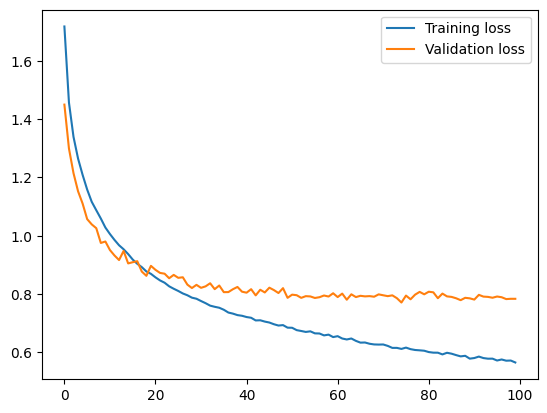

In [15]:
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {best_loss:.4f}")

epochs = range(nb_epochs)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [16]:
#Test on val data
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


40it [00:01, 34.39it/s]

Loss_test: 0.7836


<Axes: >

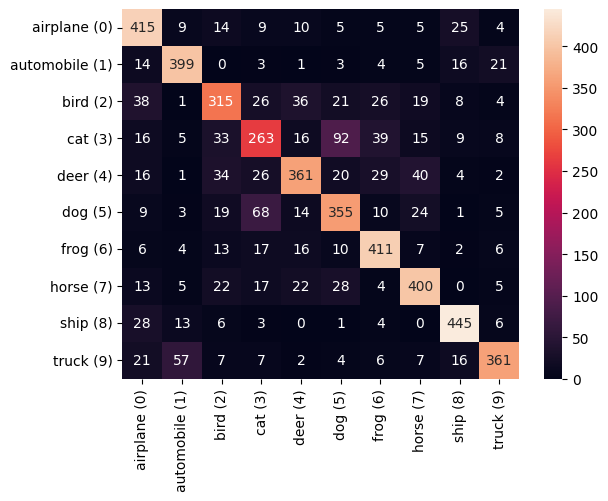

In [17]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [18]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.745


In [19]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
ship (8)        0.879447
automobile (1)  0.856223
frog (6)        0.835366
airplane (0)    0.828343
horse (7)       0.775194
truck (9)       0.739754
dog (5)         0.698819
deer (4)        0.677298
bird (2)        0.637652
cat (3)         0.530242
Mean of accuracies:  0.7458337846552595


In [20]:
checkpoint = {
    "model": best_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best_loss": best_loss,
    "epoch": best_epoch
}

# Save to a file in the working directory
torch.save(checkpoint, "/kaggle/working/checkpoint.pth")